# Real-Time-like ECG Processing (Simulated)

Simulating real-time ECG filtering...


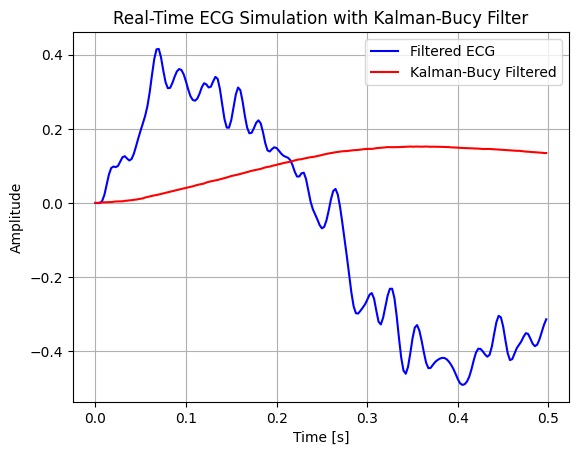

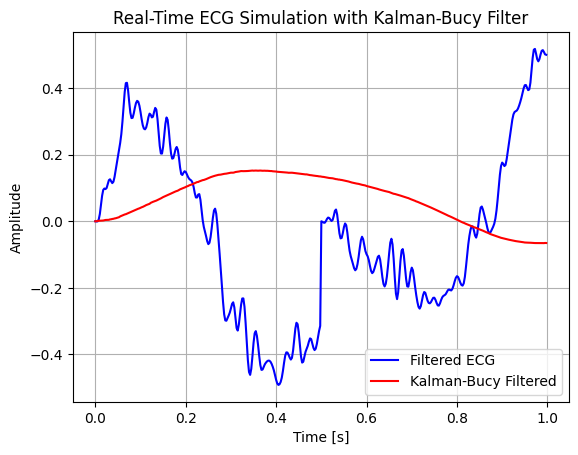

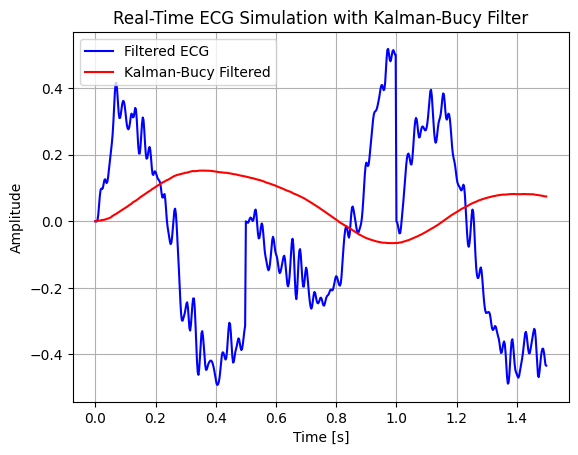

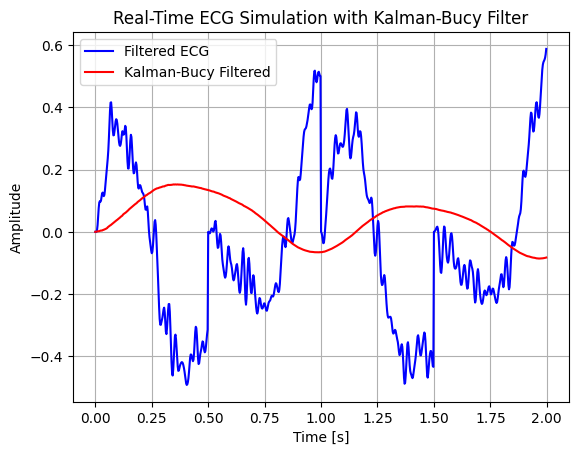

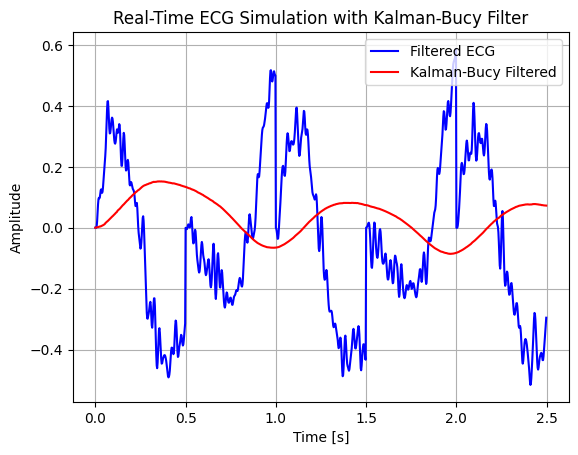

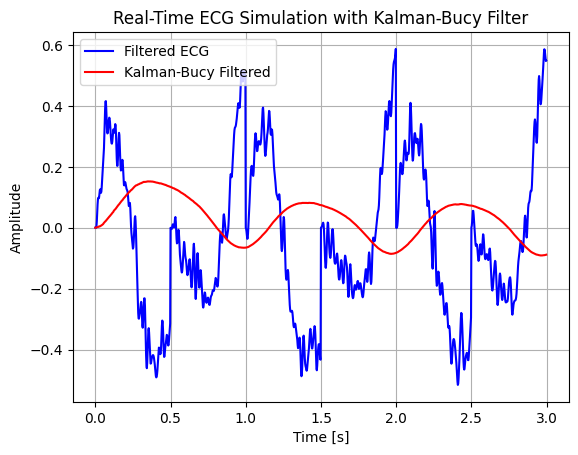

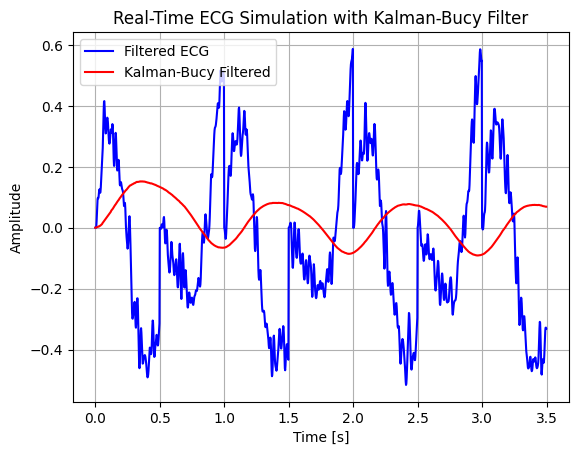

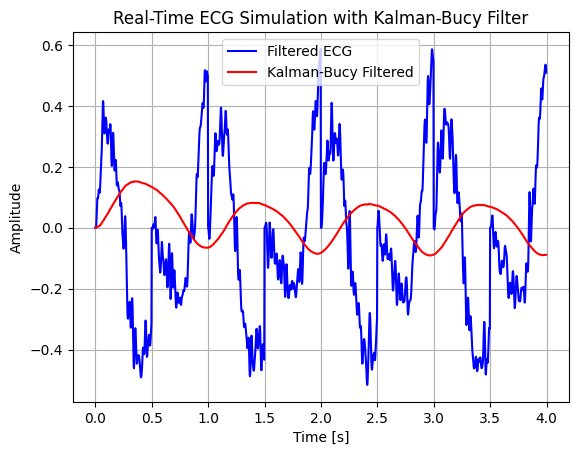

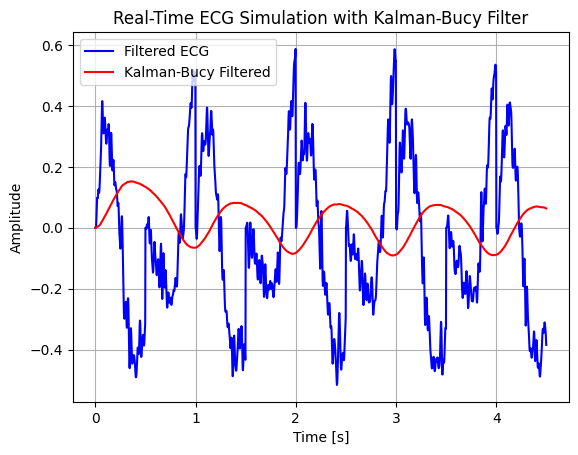

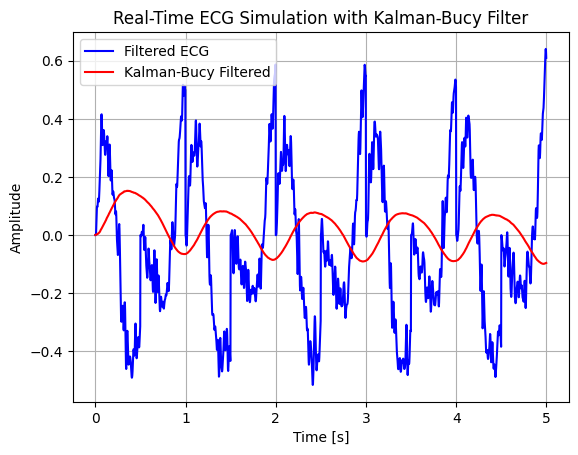

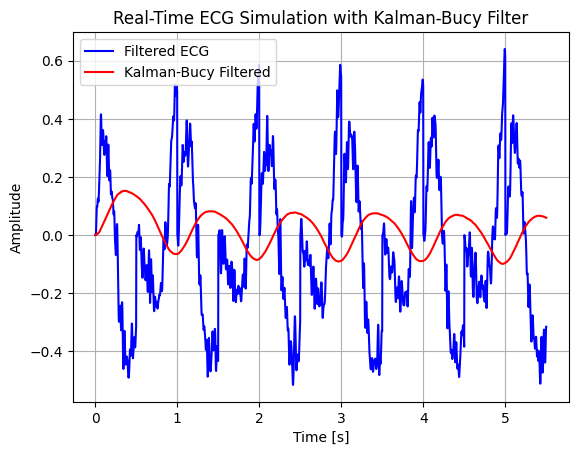

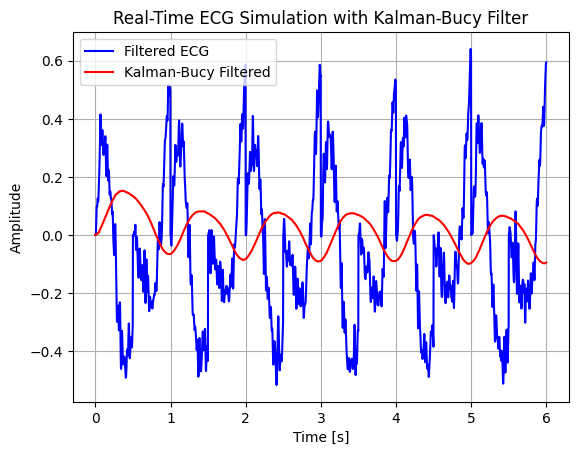

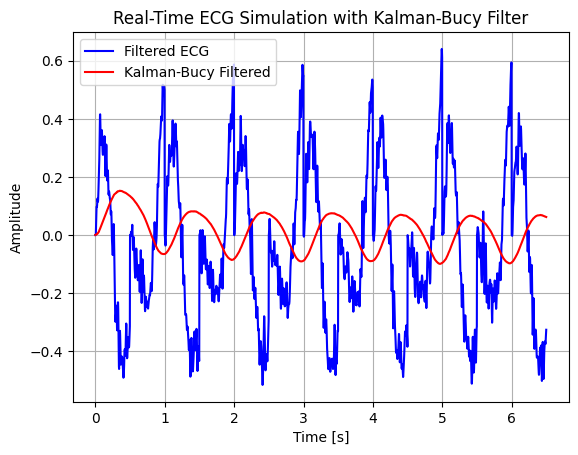

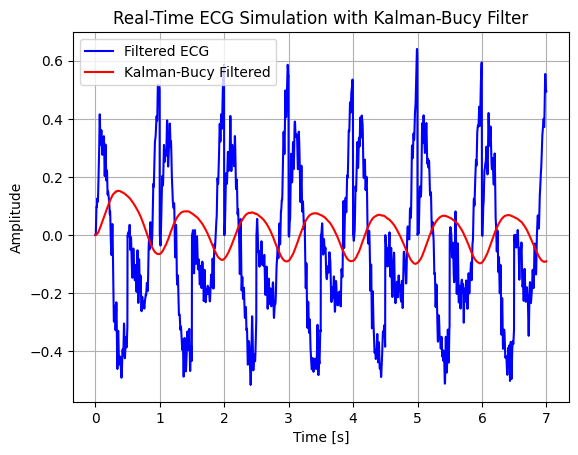

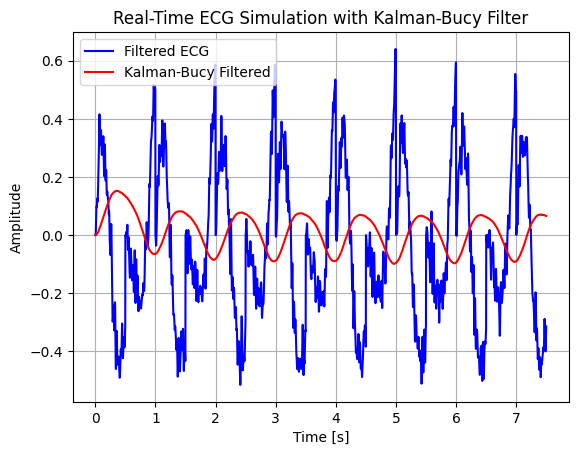

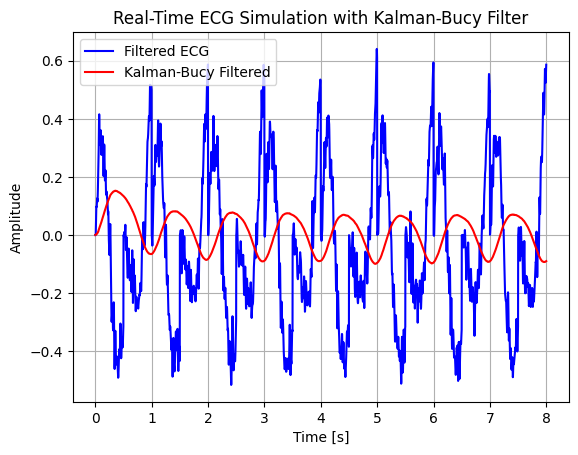

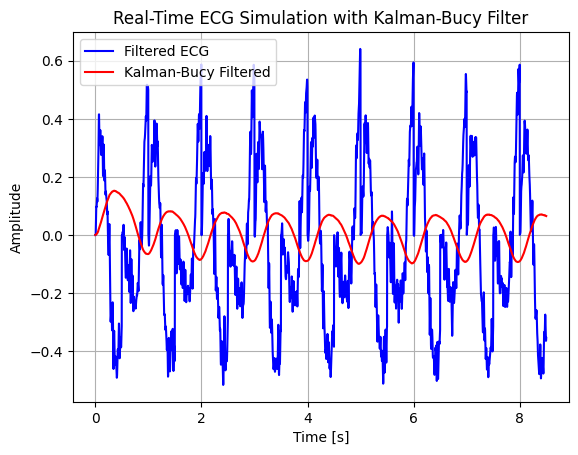

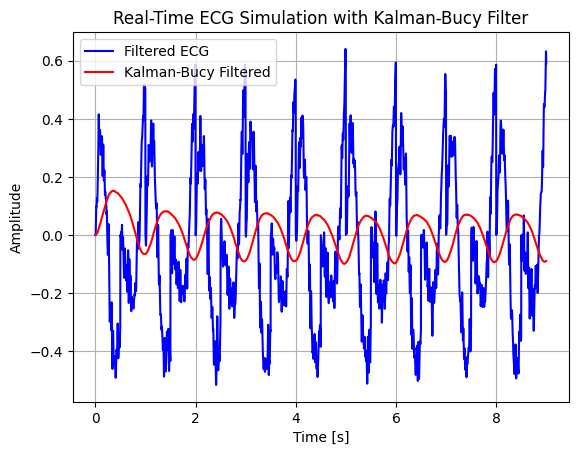

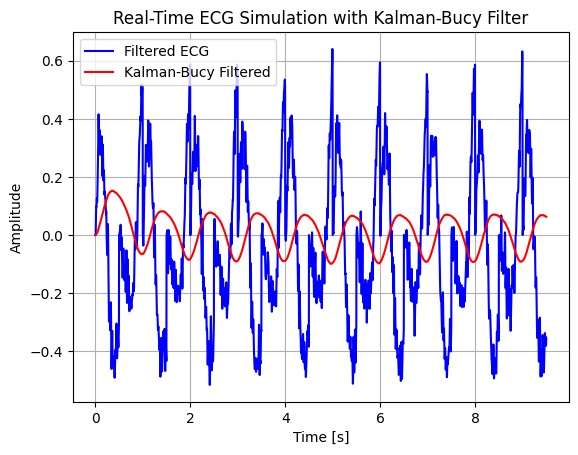

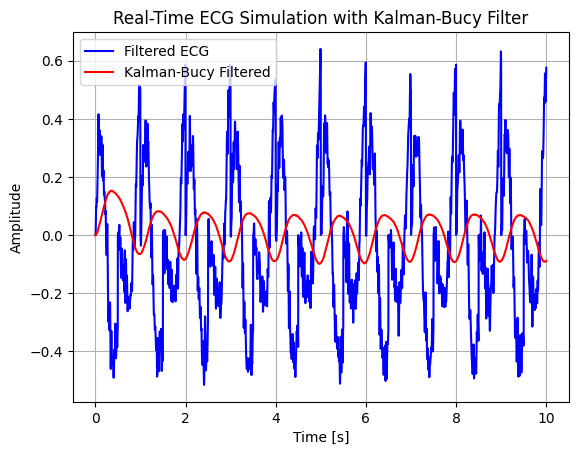

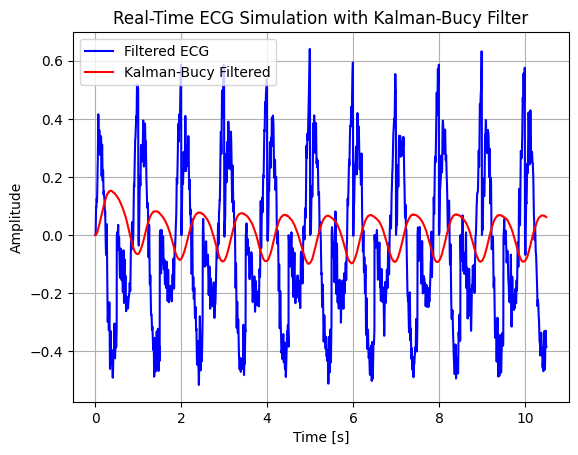

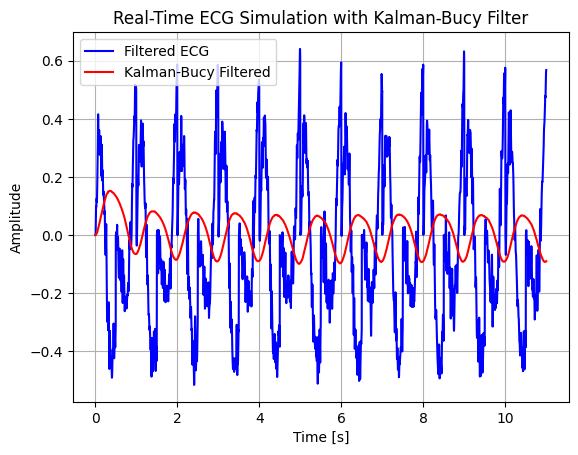

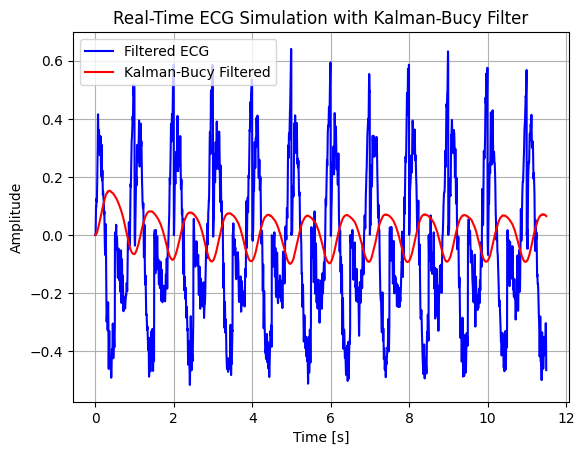

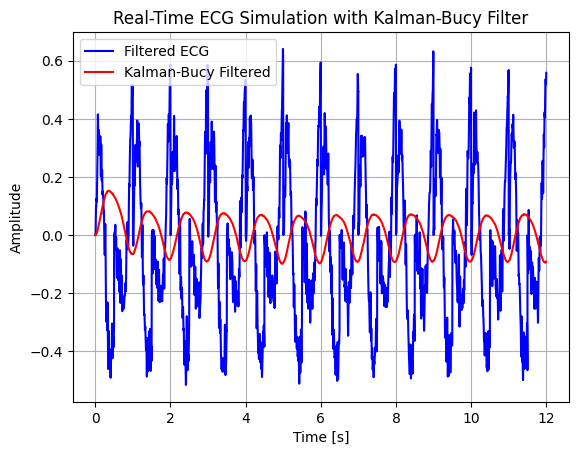

KeyboardInterrupt: 

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.signal import butter, lfilter

# --- 1. Generate synthetic ECG-like signal ---
def synthetic_ecg(fs, duration, heart_rate=60):
    t = np.linspace(0, duration, int(fs * duration))
    # Basic ECG-like waveform (sum of sinusoids)
    ecg = 0.6 * np.sin(2 * np.pi * heart_rate/60 * t) \
        + 0.2 * np.sin(2 * np.pi * 2 * heart_rate/60 * t) \
        + 0.1 * np.random.randn(len(t))  # Add noise
    return t, ecg

# --- 2. Bandpass filter (0.5–40 Hz) ---
def bandpass_filter(signal, fs, lowcut=0.5, highcut=40.0, order=4):
    nyq = 0.5 * fs
    low, high = lowcut / nyq, highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return lfilter(b, a, signal)

# --- Kalman-Bucy Filter Implementation ---
class KalmanBucyFilter:
    def __init__(self, dt=1/400):
        # Parameters
        self.A = -0.8 # From x = -0.8x + w
        self.C = 1.0 # From y = x + v
        self.Q = 1.5 # Process noise covariance
        self.R = 0.7 # Measurement noise covarianc
        self.P = 1.0 # Initial error covariance 
        self.x_hat = 0.0 # Initial state estimate
        self.dt = dt # Time step (1/sampling rate)
        
    def update(self, y):
        # Kalman gain
        K = self.P * self.C / self.R
        
        # State update
        self.x_hat += self.dt * (self.A * self.x_hat + K * (y - self.C * self.x_hat))
        
        # Covariance update
        self.P += self.dt * (2 * self.A * self.P + self.Q - K * self.C * self.P)
        
        return self.x_hat

# --- 3. Simulate real-time processing ---
def simulate_real_time_processing(ecg_signal, fs, block_size=200):
    total_samples = len(ecg_signal)
    num_blocks = total_samples // block_size
    delay = block_size / fs

    processed_signal = []
    kalman_signal = []
    t_axis = []

    # Initialize Kalman-Bucy filter
    kf = KalmanBucyFilter(dt=1/fs)

    print("Simulating real-time ECG filtering...")

    for i in range(num_blocks):
        block = ecg_signal[i*block_size:(i+1)*block_size]

        filtered = bandpass_filter(block, fs)
        processed_signal.extend(filtered)

        #Apply Kalman-Bucy filter
        kalman_block = []
        for sample in block:
            kalman_estimate = kf.update(sample)
            kalman_block.append(kalman_estimate)
        kalman_signal.extend(kalman_block)

        t_axis.extend(np.arange(i*block_size, (i+1)*block_size)/fs)

        # Optional: plot dynamic update (comment out for performance)
        plt.clf()
        plt.plot(t_axis, processed_signal, label="Filtered ECG", color='blue')
        plt.plot(t_axis, kalman_signal, label="Kalman-Bucy Filtered", color='red')
        plt.xlabel("Time [s]")
        plt.ylabel("Amplitude")
        plt.title("Real-Time ECG Simulation with Kalman-Bucy Filter")
        plt.grid(True)
        plt.legend()
        plt.pause(0.01)  # Live update

        time.sleep(delay)  # Simulate real-time delay

    plt.show()

# --- Run simulation ---
fs = 400           # Sampling frequency (Hz)
duration = 15      # Signal duration (s)
t, ecg = synthetic_ecg(fs, duration)

simulate_real_time_processing(ecg, fs, block_size=200)